In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
from numpy.linalg import inv
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10


In [58]:
os.chdir('/Users/sreelakshmirajendrakumar/Downloads')

dataset = pandas.read_csv('LDA_1.csv')
y_data=dataset.iloc[:,0]
y_data=y_data.to_numpy() # shape (4999,)
X_data=dataset.iloc[:,1:]
X_data=X_data.to_numpy() # shape (4999,10)

#appending the missing row from the dataset
firstValues=list(dataset.columns.values)
for i in range(0,11):
    firstValues[i]=float(firstValues[i])
X_data=np.concatenate(([firstValues[1:]],X_data),axis=0) # shape (5000,10)
y_data=np.append(firstValues[0],y_data) #shape (5000,)
y_data=y_data.astype(int)



In [59]:
# when N=20
X_test20 = X_data[0:5000-20] # shape (4980,10)
X_train20 = X_data[5000-20:] # shape (20,10)
y_test20 = y_data[0:5000-20] # shape (4980,)
y_train20 = y_data[5000-20:] # shape (20,)

# when N=50
X_test50 = X_data[0:5000-50] # shape (4950,10)
X_train50 = X_data[5000-50:] # shape (50,10)
y_test50 = y_data[0:5000-50] # shape (4950,)
y_train50 = y_data[5000-50:] # shape (50,)

# when N=100
X_test100 = X_data[0:5000-100] # shape (4900,10)
X_train100 = X_data[5000-100:] # shape (100,10)
y_test100 = y_data[0:5000-100] # shape (4900,)
y_train100 = y_data[5000-100:] # shape (100,)

# when N=200
X_test200 = X_data[0:5000-200] # shape (4800,10)
X_train200 = X_data[5000-200:] # shape (200,10)
y_test200 = y_data[0:5000-200] # shape (4800,)
y_train200 = y_data[5000-200:] # shape (200,)

# when N=1000
X_test1000 = X_data[0:5000-1000] # shape (4000,10)
X_train1000 = X_data[5000-1000:] # shape (1000,10)
y_test1000 = y_data[0:5000-1000] # shape (4000,)
y_train1000 = y_data[5000-1000:] # shape (1000,)

# when N=2500
X_test2500 = X_data[0:5000-2500] # shape (2500,10)
X_train2500 = X_data[5000-2500:] # shape (2500,10)
y_test2500 = y_data[0:5000-2500] # shape (2500,)
y_train2500 = y_data[5000-2500:] # shape (2500,)




In [60]:
def meanX(X): # X is an Nxd (or N_ixd) matrix
    # finding the mean over the samples in the array given as input
    X=np.array(X)
    mean=[]
    (N,d)=np.shape(X)
    for i in range(0,d):
        temp=((np.sum(X[:,i]))/N)
        mean.append([temp])
    return mean # dx1 matrix

def separateClass(X,y):
    # separates the main array into classes so that the length of this array
    #will be the number of classes, shape of each element in this array will 
    #be (N_i,d) where N_i is the number of samples in  i^th class
    (N,d)=np.shape(X)
    q=np.max(y)-np.min(y)+1 # the number of classes
    x_separated=[]
    for i  in range(0,q):
        x_separated.append([])
    for c in range(1,q+1):
        for i in range(0,N):
            if y[i]==c:
                x_separated[c-1].append(X[i])
    return x_separated

def meanDiff(X,y):
    #gets the matrix (mu_g-mu)
    X=np.array(X)
    (N,d)=np.shape(X)
    q=np.max(y)-np.min(y)+1
    x_separated=separateClass(X,y)
    theMean=meanX(X)
    theMean=np.array(theMean).T[0]
    means=[] # to collect the mean for each class
    for i in range(0,q):
        temp=np.array(meanX(x_separated[i])).T
        means.append(temp[0])
    meanDifference=means-theMean
    xMeanDifference=np.array(X)-theMean
        
    return meanDifference.T,xMeanDifference.T # shapes (d,q), (d,N) ==> this will go as the input for finding the gamma values
    
def withinClassScatter(X,y): # input: x_separated
    (N,d)=np.shape(X)
    q=np.max(y)-np.min(y)+1
    x_separated=separateClass(X,y)
    withinScatter=np.zeros((d,d))
    for i in range(0,q):
        x_separated[i]=np.array(x_separated[i]) # 1xd matrix
        temp=x_separated[i].T # dx1 matrix
        temp1=meanX(x_separated[i]) #dx1 matrix
        temp2=np.subtract(temp,temp1)
        temp3=np.matmul(temp2,temp2.T) # dxd matrix
        withinScatter+=temp3
    return withinScatter/N

def betweenClassScatter(X,y):
    (N,d)=np.shape(X)
    q=np.max(y)-np.min(y)+1
    x_separated=separateClass(X,y)
    x_mean=meanX(X) # dx1 matrix
    x_separatedMeans=[]
    theCount=[]
    betweenScatter=np.zeros((d,d))
    for i in range(0,q):
        count=0
        x_separatedMeans.append(meanX(x_separated[i])) # this will be a matrix with length q when the for loop ends
        for j in range(0,len(x_separated[i])):
            count+=1
        theCount.append(count) # array that has the number of elements of each class
    
    for i in range(0,q):
        temp=np.subtract(x_separatedMeans[i],x_mean)
        temp2=np.matmul(temp,temp.T)
        betweenScatter+=temp2
    return betweenScatter/N # dxd matrix


def LDATrain(X,y):
    (N,d)=np.shape(X)
    globalAverage=meanX(X)
    q=np.max(y)-np.min(y)+1
    r=q-1
    withinScatter=withinClassScatter(X,y)
    betweenScatter=betweenClassScatter(X,y)
    temp=np.linalg.inv(withinScatter)
    temp1=np.matmul(temp,betweenScatter)
    tempWeight,tempVec=np.linalg.eig(temp1) # tempVec[:,i] is the eigenvector for tempWeight[i]
    # sorting step
    tempWeightSorted=sorted(tempWeight,reverse=True)
    tempVector=tempVec.T
    tempVecSorted=[]
    for i in range(0,len(tempWeight)):
        for j in range(0,len(tempWeight)):
            if tempWeightSorted[i]==tempWeight[j]:
                tempVecSorted.append(tempVector[j])
    eigenVectors=tempVecSorted[0:r] # first r eigen vectors
    eigenVectors=np.array(eigenVectors).T 
    # computing (mu_g-mu).T x e_j
    difference,x_difference=meanDiff(X,y) # dxq and dxN
    difference=np.array(difference).T
    x_difference=np.array(x_difference).T
    m_c=[] # here the first row (for both xm_c and m_c) will have the multiplication by the first eigen vector, second will have that by the second vector, and so on    
    for i in range(0,r):
        m_c.append([])
        for g in range(0,q):
            temp3=np.matmul(difference[g],eigenVectors.T[i])
            m_c[i].append(temp3)
        #m_c=np.matmul(difference.T,eigenVectors)
    
    return eigenVectors,globalAverage,m_c # dxr ,dx1, rxq, rxN


def LDAClassifyAndPlot(X,y,X_test,y_test):
    predictedY=[]
    (N,d)=np.shape(X)
    (N_test,d_test)=np.shape(X_test)
    q=np.max(y)-np.min(y)+1
    r=q-1
    x_separated=separateClass(X,y)
    eigenVectors,globalAverage,m_c=LDATrain(X,y)
    pred=[]
    xm_c=[]
    difference,x_difference=meanDiff(X_test,y_test) # dxq and dxN
    difference=np.array(difference).T
    x_difference=np.array(x_difference).T
    for i in range(0,r):
        xm_c.append([])
        for j in range(0,N_test):
            temp2=np.matmul(x_difference[j],eigenVectors.T[i])
            xm_c[i].append(temp2) # xm_c is now an rxN matrix
    for i in range(0,N_test):
        toPred=[]
        for g in range(0,q):
            pi=len(x_separated[g]) # getting the value of pi
            temp=0
            temp1=0
            for j in range(0,r):
                temp+=xm_c[j][i]*m_c[j][g]
                temp1+=m_c[j][g]**2
            temp1/=2
            temp2=temp-temp1+np.log(pi)
            toPred.append(temp2)
        ind=np.argmax(toPred)
        pred.append(ind)
        
    # getting the test set projected on to the first two discriminants for plotting
    toPlot=[]
    for i in range(0,2):
        toPlot.append([])
        for j in range(0,N_test):
            temp2=np.matmul(x_difference[j],eigenVectors.T[i])
            toPlot[i].append(temp2) # xm_c is now an rxN matrix
        
    label=np.array(pred)+1
    labels=[]
    #labels=np.array(labels).astype(str)
    for ind in range(0,len(label)):
        labels.append('Class_'+str(label[ind]))
    data={'X1':toPlot[0],'X2':toPlot[1],'Labels':labels}
    fig=sns.scatterplot(x='X1',y='X2',hue='Labels',data=data)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('The test set projected on the first two discriminant directions when N='+str(5000-len(label)))
    plt.figure(figsize=(20,20))
    
    return toPlot


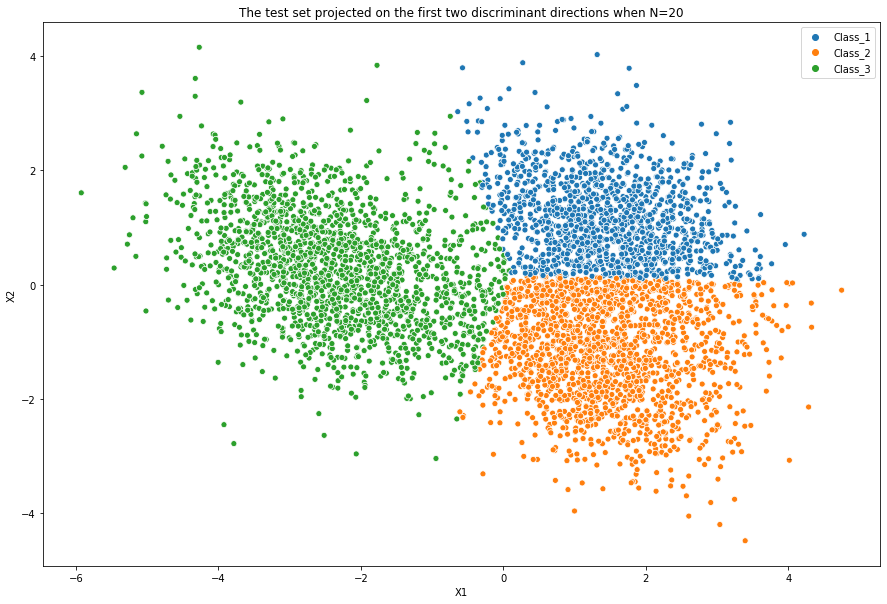

<Figure size 1440x1440 with 0 Axes>

In [61]:
'''Applying LDA when N=20'''
yPredict_20=LDAClassifyAndPlot(X_train20,y_train20,X_test20,y_test20)

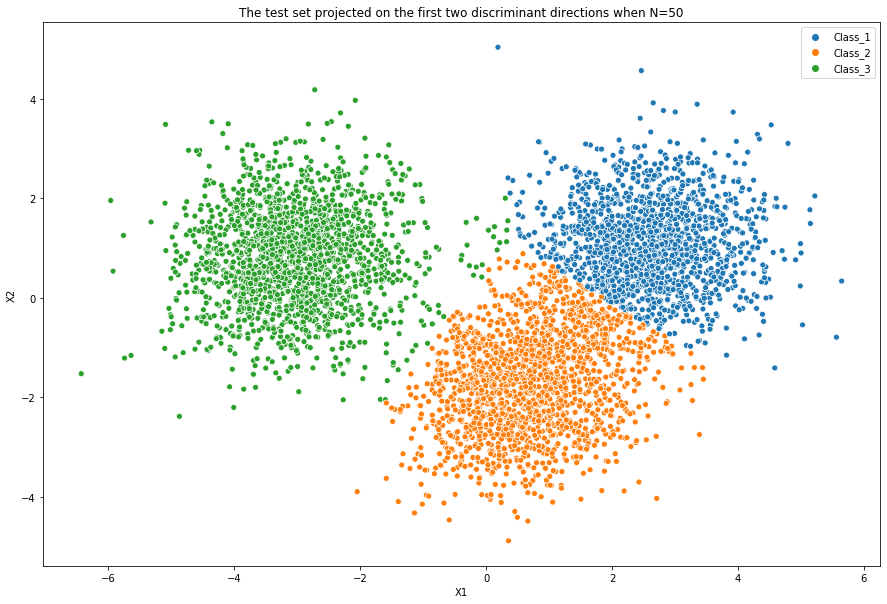

<Figure size 1440x1440 with 0 Axes>

In [62]:
'''Applying LDA when N=50'''
yPredict_50=LDAClassifyAndPlot(X_train50,y_train50,X_test50,y_test50)

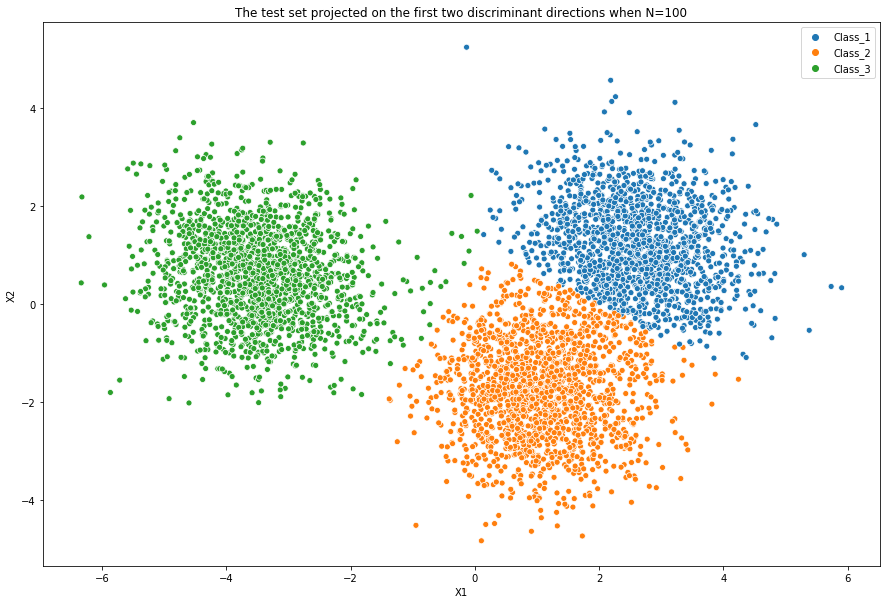

<Figure size 1440x1440 with 0 Axes>

In [63]:
'''Applying LDA when N=100'''
yPredict_100=LDAClassifyAndPlot(X_train100,y_train100,X_test100,y_test100)

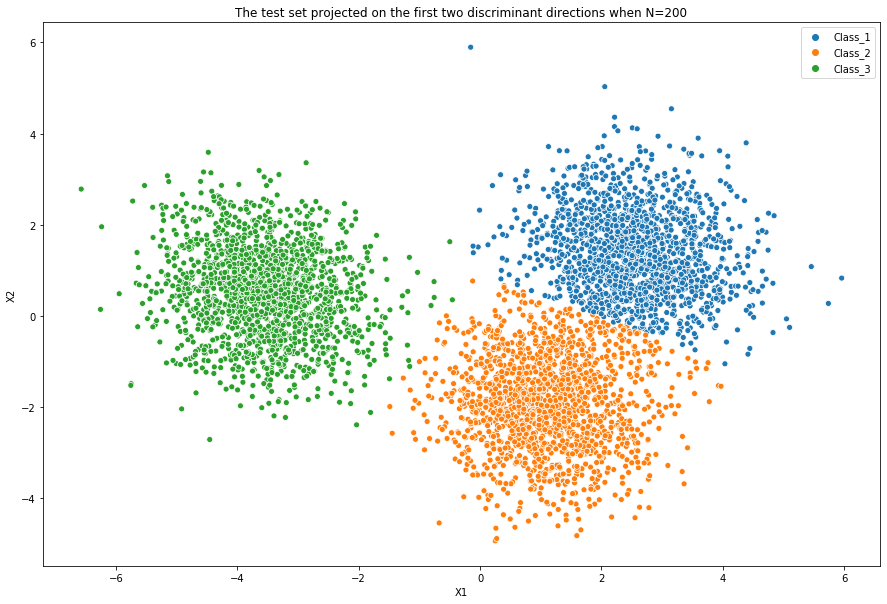

<Figure size 1440x1440 with 0 Axes>

In [64]:
'''Applying LDA when N=200'''
yPredict_200=LDAClassifyAndPlot(X_train200,y_train200,X_test200,y_test200)

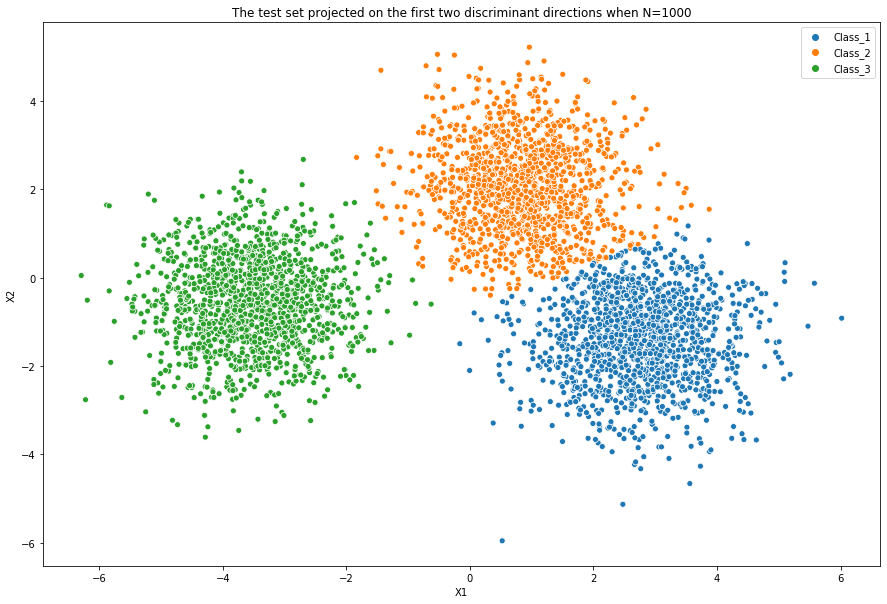

<Figure size 1440x1440 with 0 Axes>

In [65]:
'''Applying LDA when N=1000'''
yPredict_1000=LDAClassifyAndPlot(X_train1000,y_train1000,X_test1000,y_test1000)

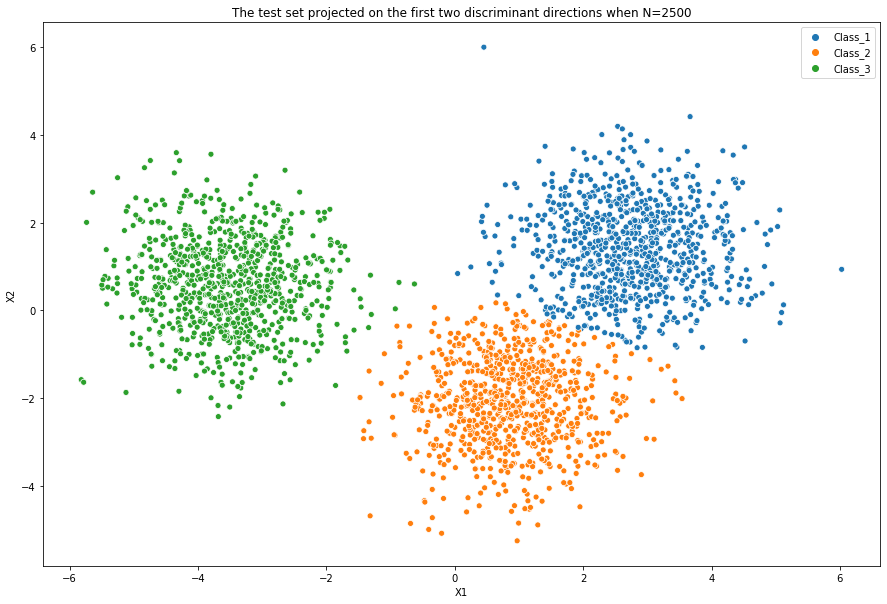

<Figure size 1440x1440 with 0 Axes>

In [67]:
'''Applying LDA when N=2500'''
yPredict_2500=LDAClassifyAndPlot(X_train2500,y_train2500,X_test2500,y_test2500)